# Imports de bibliotecas necessárias

In [2]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# Definir los directorios y variables estaticas
root_dir = 'png-dataset'
train_dir = 'png-train-dataset'
val_dir = 'png-val-dataset'

In [4]:
# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Cargar los datos de entrenamiento y validación
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# configurar el tamaño de los hiperparametros de los batch
batch_size = 32

# convertir los datos a iterables (batches)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Imprimir el tamaño de los datasets
print(f"DataLoaders: {train_loader, val_loader}")
print(f"longitud de train_loader: {len(train_loader)} batches de {batch_size} = {len(train_loader)*batch_size} imágenes")
print(f"longitud de train_loader: {len(val_loader)} batches de {batch_size} = {len(val_loader)*batch_size} imágenes")

# comprobamos el interior de los datos de entrenamiento en el Data Loader
train_feature_batch, train_labels_batch = next(iter(train_loader))
train_feature_batch.shape, train_labels_batch.shape

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022BC71ADF10>, <torch.utils.data.dataloader.DataLoader object at 0x0000022BC7782810>)
longitud de train_loader: 2093 batches de 32 = 66976 imágenes
longitud de train_loader: 524 batches de 32 = 16768 imágenes


(torch.Size([32, 3, 128, 128]), torch.Size([32]))

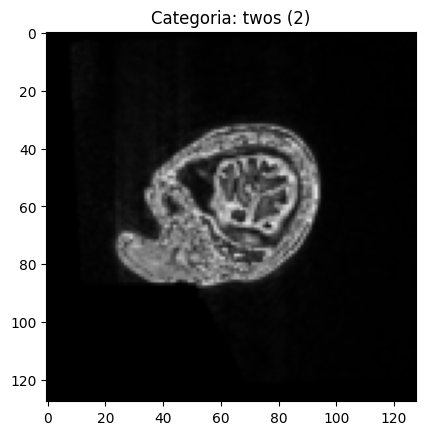

In [5]:
import matplotlib.pyplot as plt

def show_image(img, label):
    # Desnormalizar la imagen
    img = img * 0.5 + 0.5  # Deshace la normalización
    img = img.permute(1, 2, 0)  # Reorganizar las dimensiones para imshow
    img = img.numpy()  # Convertir a numpy
    
    plt.imshow(img)
    plt.title(f"Categoria: {train_dataset.classes[label]} ({label})")
    plt.show()

# Mostrar una imagen de ejemplo normalizada
img, label = train_dataset[60000]
show_image(img, label)



# Funciones utiles para el uso de GPU

In [6]:
import torch

def get_default_device():
    #Escoge la GPU si está disponible, de lo contrario la CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Mueve los tensores a la GPU
    if isinstance(data, (list, tuple)):
        return [to_device(x, device)for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Envuelve un DataLoader para mover los datos a un dispositivo
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    #Itera sobre los batches del DataLoader
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    #Devuelve el número de batches
    def __len__(self):
        return len(self.dl)
    

In [7]:
device = get_default_device()
device

device(type='cuda')

# Modelo CNN 2D

In [8]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [9]:
# Funciones de utilidad para entrenar el modelo
import torch.nn as nn

class CustomCNNBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generar predicciones
        loss = F.cross_entropy(out, labels) # Calcular la pérdida
        acc = accuracy(out, labels)         # Calcular la precisión
        return loss, acc

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina las pérdidas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina las precisiones
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
            
    def validation_step(self, batch):
            images, labels = batch 
            out = self(images)                    # Generar predicciones
            loss = F.cross_entropy(out, labels)   # Calcular la pérdida
            acc = accuracy(out, labels)           # Calcular la precisión
            return {'val_loss': loss.detach(), 'val_acc': acc}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
# Revisamos el tamaño de las imágenes
for images, labels in train_dataset:
    print('images shape is: ', images.shape)
    break

images shape is:  torch.Size([3, 128, 128])


In [11]:
# Definir la arquitectura del modelo
import torch.optim as optim
import torch.nn.functional as F

class Custom2DCNN(CustomCNNBase):
    def __init__(self):
        super(Custom2DCNN, self).__init__()
        #Imagen de entrada: 3 x 128 x 128

        # Primera capa convolucional (Entrada: 3 x 128 x 128, Salida: 32 x 128 x 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Entrada: 32 x 128 x 128 - Salida: 32 x 64 x 64
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Segunda capa convolucional (Entrada: 32 x 64 x 64, Salida: 64 x 64 x 64) -> Salida MaxPool: 64 x 32 x 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Tercera capa convolucional (Entrada: 64 x  32 x 32, Salida: 128 x  32 x 32) -> Salida MaxPool: 128 x 16 x 16
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        # Capa completamente conectada 1 (entrada: 128 x  32 x 32, salida: 512)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        # Capa completamente conectada 2 (entrada: 512, salida: 128)
        self.fc2 = nn.Linear(512, 3)


    def forward(self, x):
        # Aplicar primera capa convolucional y max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplicar segunda capa convolucional y max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplicar tercera capa convolucional
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten
        x = self.flatten(x)
        # Aplicar primera capa completamente conectada
        x = F.relu(self.fc1(x))
        # Aplicar segunda capa completamente conectada
        x = self.fc2(x)
        return x

In [12]:
# Instanciamos el modelo y lo enviamos al dispositivo cuda o cpu
model = Custom2DCNN()
model.to(device)

Custom2DCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

# Funcion para evaluar y entrenar

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Fase de entrenamiento
        model.train()
        train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            loss, acc = model.training_step(batch)           
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Fase de validación
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0009

In [15]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.6613, val_loss: 0.5043, val_acc: 0.7688
Epoch [1], train_loss: 0.4213, val_loss: 0.3727, val_acc: 0.8248
Epoch [2], train_loss: 0.3248, val_loss: 0.3508, val_acc: 0.8429
Epoch [3], train_loss: 0.2824, val_loss: 0.2711, val_acc: 0.8728
Epoch [4], train_loss: 0.2560, val_loss: 0.2851, val_acc: 0.8656
Epoch [5], train_loss: 0.2307, val_loss: 0.2885, val_acc: 0.8633
Epoch [6], train_loss: 0.2203, val_loss: 0.2402, val_acc: 0.8886
Epoch [7], train_loss: 0.2072, val_loss: 0.2476, val_acc: 0.8835
Epoch [8], train_loss: 0.1982, val_loss: 0.2573, val_acc: 0.8813
Epoch [9], train_loss: 0.1924, val_loss: 0.2207, val_acc: 0.8969


# Evaluación del modelo

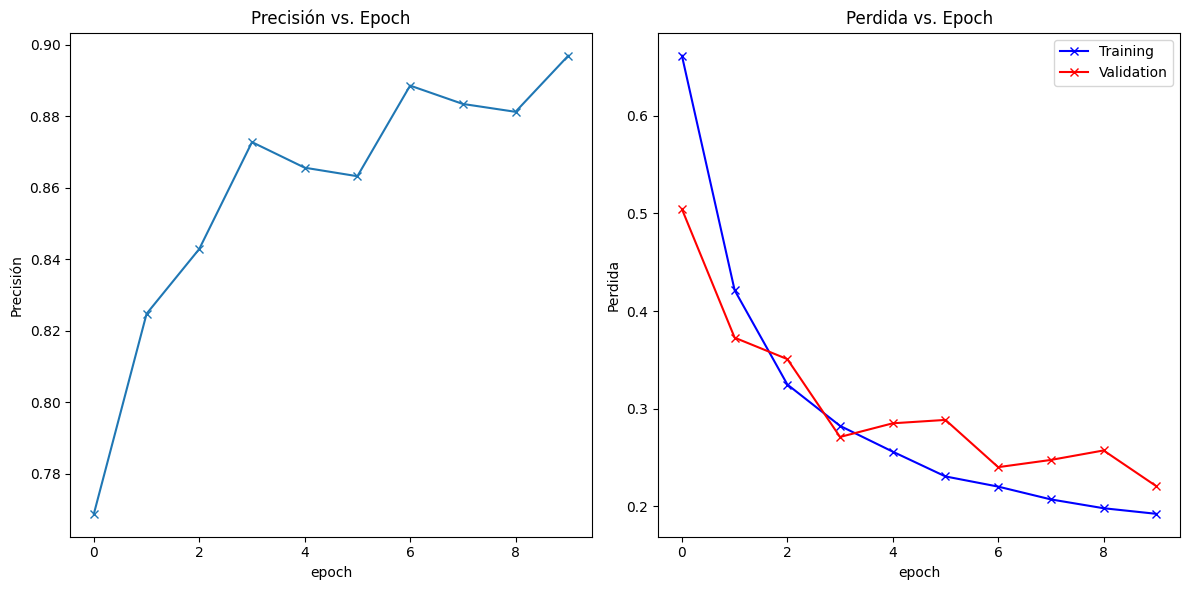

In [16]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Ancho: 12 pulgadas, Altura: 6 pulgadas

# Gráfico de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Precisión')
plt.title('Precisión vs. Epoch')

# Gráfico de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('Perdida')
plt.legend(['Training', 'Validation'])
plt.title('Perdida vs. Epoch')

# Mostrar los gráficos
plt.tight_layout()  # Ajustar el diseño para que no se superpongan los gráficos
plt.show()

# Test del modelo con una imagen del dataset de validación

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].


Categoria Correcta: twos , Predicción: twos


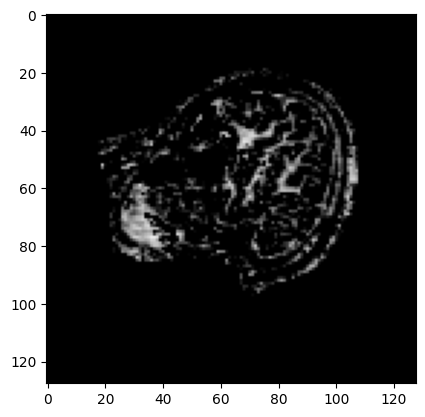

In [17]:
def test_image(img, model):
    # Convertir la imagen a un batch de un solo elemento
    xb = to_device(img.unsqueeze(0), device)
    # Obtener las predicciones del modelo
    yb = model(xb)
    # Escoger el punto de entrenamiento con la mayor probabilidad
    _, preds  = torch.max(yb, dim=1)
    return val_dataset.classes[preds[0].item()]

# Seleccionar una imagen random del dataset de validación
random = torch.randint(0, len(val_dataset), (1,)).item()
img, label = val_dataset[random]
plt.imshow(img.permute(1, 2, 0))
print('Categoria Correcta:', val_dataset.classes[label], ', Predicción:', test_image(img, model))

# Guardamos el modelo

In [18]:
torch.save(model.state_dict(), 'Custom2DCNN_v0_128.pth')